In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model

import joblib

In [3]:
df = pd.read_csv(r"..\Excel\smart_allocation_engine_raw_data.csv")

df.head()

,Ticker,Report Date,Currency,Fiscal Year,Fiscal Period,Revenue Growth YoY,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Net Income (Common),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income,Profit Margin
0,A,31-10-2019,USD,2019,FY,0.05%,19-12-2019,17-12-2021,320742324.6,308841934.8,...,9.739130e+08,-21540449.8,-39609250.3,8.757926e+08,1.087814e+09,9.014980e+08,153623039.2,1.020157e+09,1.028148e+09,20.17%
1,A,31-10-2020,USD,2020,FY,0.05%,18-12-2020,21-12-2022,304923596.7,324559982.1,...,8.599826e+08,-3843030.6,-69428330.8,8.821196e+08,7.250344e+08,8.622497e+08,-119147130.8,7.016688e+08,7.474341e+08,14.19%
2,A,31-10-2021,USD,2021,FY,0.05%,17-12-2021,20-12-2023,302745756.8,291826737.8,...,1.360027e+09,13503413.5,-78206874.9,1.369544e+09,1.229461e+09,1.382063e+09,-150126196.8,1.189369e+09,1.269765e+09,19.57%
3,A,31-10-2022,USD,2022,FY,0.05%,21-12-2022,20-12-2024,302920176.7,293227801.5,...,1.629868e+09,-118035925.0,-76804761.7,1.511038e+09,1.264476e+09,1.452603e+09,-259791253.9,1.295889e+09,1.220533e+09,17.91%
4,A,31-10-2023,USD,2023,FY,-0.20%,20-12-2023,20-12-2024,295858524.1,296171413.7,...,1.343784e+09,-11236478.9,-45954486.5,1.362767e+09,1.279250e+09,1.298291e+09,-97242376.2,1.284174e+09,1.259117e+09,18.91%


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Ticker                                    80000 non-null  object 
 1   Report Date                               80000 non-null  object 
 2   Currency                                  80000 non-null  object 
 3   Fiscal Year                               80000 non-null  int64  
 4   Fiscal Period                             80000 non-null  object 
 5   Revenue Growth YoY                        75606 non-null  object 
 6   Publish Date                              80000 non-null  object 
 7   Restated Date                             80000 non-null  object 
 8   Shares (Basic)                            79319 non-null  float64
 9   Shares (Diluted)                          78691 non-null  float64
 10  Revenue                           

In [271]:
df.describe()

,Fiscal Year,Shares (Basic),Shares (Diluted),Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Net Income (Common),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income
count,80000.000000,7.931900e+04,7.869100e+04,7.174900e+04,6.274800e+04,6.276300e+04,7.981000e+04,7.565200e+04,3.744300e+04,3.233700e+04,7.997800e+04,7.883400e+04,6.999500e+04,7.997800e+04,8.000000e+04,7.998200e+04,6.416600e+04,8.000000e+04,8.000000e+04
mean,2021.017713,3.272038e+08,1.185780e+11,6.999327e+09,-4.810686e+09,3.058574e+09,-1.899751e+09,-8.673550e+08,-8.268207e+08,-1.169066e+09,6.237811e+08,-1.233239e+08,-1.973676e+08,5.195937e+08,3.933545e+08,4.241812e+08,-1.224606e+08,4.035221e+08,3.964271e+08
std,1.386659,6.971702e+09,9.491823e+12,1.061218e+11,6.501118e+10,5.390281e+10,4.325171e+10,1.683375e+10,4.340337e+10,4.291865e+10,2.634805e+10,8.946581e+09,1.125537e+10,2.450570e+10,1.899921e+10,2.643003e+10,7.501236e+09,1.893683e+10,1.904718e+10
min,2019.000000,1.000000e+00,1.000000e+00,-1.951760e+11,-7.917420e+12,-5.873975e+09,-4.783560e+12,-2.346500e+12,-3.855540e+12,-3.521510e+12,-2.059180e+12,-1.037130e+12,-1.441040e+12,-1.650820e+12,-1.453300e+12,-1.617500e+12,-5.101530e+11,-1.352410e+12,-1.465450e+12
25%,2020.000000,1.929684e+07,2.001514e+07,1.080633e+08,-1.886028e+09,6.445579e+07,-6.965905e+08,-3.996519e+08,-1.268526e+08,-2.266965e+08,-2.335665e+07,-4.668634e+07,-6.665252e+07,-3.222659e+07,-4.411249e+07,-4.360850e+07,-5.055868e+07,-4.343431e+07,-4.302754e+07
50%,2021.000000,4.988151e+07,5.138149e+07,6.527932e+08,-3.879232e+08,3.244066e+08,-1.971626e+08,-1.002825e+08,-4.339879e+07,-5.257560e+07,1.445617e+07,-3.971888e+06,-9.224227e+06,4.491974e+06,5.704619e+05,1.616831e+06,-4.132217e+06,1.035094e+06,9.618371e+05
75%,2022.000000,1.319420e+08,1.363625e+08,2.941338e+09,-6.093375e+07,1.258199e+09,-5.058654e+07,-2.269299e+07,-1.186272e+07,-1.066924e+07,2.483857e+08,2.640572e+05,-1.560197e+05,1.926331e+08,1.348403e+08,1.716021e+08,-1.344967e+04,1.405791e+08,1.370231e+08
max,2024.000000,7.099130e+11,8.333040e+14,1.281360e+13,3.134478e+09,5.538630e+12,9.695547e+08,3.864434e+07,1.297686e+08,3.073519e+06,3.138550e+12,4.357030e+11,2.032180e+11,2.790580e+12,2.258920e+12,2.842190e+12,7.715720e+11,2.281810e+12,2.209660e+12


In [272]:
# Ensure chronological order
df = df.sort_values(["Ticker","Fiscal Year"])

# Growth features (NO forward fill)
df["Revenue_Growth"] = df.groupby("Ticker")["Revenue"].pct_change(fill_method=None)
df["NI_Growth"] = df.groupby("Ticker")["Net Income"].pct_change(fill_method=None)

In [273]:
df["Revenue_Growth"] = df["Revenue_Growth"].clip(-3,3)
df["NI_Growth"] = df["NI_Growth"].clip(-3,3)

In [274]:
df["Profit_Margin"] = df["Net Income"] / df["Revenue"]

df = df.replace([np.inf,-np.inf],np.nan)
df = df.dropna(subset=["Revenue_Growth","NI_Growth"])

In [275]:
#Build Persona Table by Aggregating Key Financial Metrics at the Ticker Level
persona = df.groupby("Ticker").agg({
    "Revenue_Growth":"mean",
    "NI_Growth":"std",
    "Profit_Margin":"mean"
}).dropna()



In [276]:
#Standardize Persona Metrics for Clustering
scaler = StandardScaler()
X_persona = scaler.fit_transform(persona)

In [277]:
#Ticker-Level KMeans Clustering to Identify Distinct Company Profiles (Personas)
kmeans = KMeans(n_clusters=4, random_state=42)
persona["Cluster_ID"] = kmeans.fit_predict(persona)

In [278]:
#Merge Persona Back to Main DataFrame
df = df.merge(persona["Cluster_ID"], on="Ticker", how="left")

In [279]:
#TEMPORAL WINDOWING TO CREATE LSTM-FRIENDLY DATA STRUCTURE
#We build [T-2,T-1,T] → T+1. This means for each fiscal year T, we use the financials from the previous 2 years (T-2 and T-1) 
#along with the current year (T) to predict the growth in net income for the next year (T+1).
rows = []

for ticker, g in df.groupby("Ticker"):
    g = g.sort_values("Fiscal Year").reset_index(drop=True)

    if len(g) < 4:
        continue

    for i in range(2, len(g)-1):

        row = {
            "Ticker": ticker,
            "Year_T": g.loc[i,"Fiscal Year"],
            "Cluster_ID": g.loc[i,"Cluster_ID"],

            "NI_T": g.loc[i,"Net Income"],
            "NI_T1": g.loc[i-1,"Net Income"],
            "NI_T2": g.loc[i-2,"Net Income"],

            "Rev_T": g.loc[i,"Revenue"],
            "Rev_T1": g.loc[i-1,"Revenue"],
            "Rev_T2": g.loc[i-2,"Revenue"],

            "Margin_T": g.loc[i,"Profit_Margin"],

            "Target_Growth": (g.loc[i+1,"Net Income"] - g.loc[i,"Net Income"]) / abs(g.loc[i,"Net Income"]),
            "Target_Direction": int(g.loc[i+1,"Net Income"] > g.loc[i,"Net Income"])
        }

        rows.append(row)

master = pd.DataFrame(rows).dropna()

In [280]:
print(master.columns.tolist())

['Ticker', 'Year_T', 'Cluster_ID', 'NI_T', 'NI_T1', 'NI_T2', 'Rev_T', 'Rev_T1', 'Rev_T2', 'Margin_T', 'Target_Growth', 'Target_Direction']


In [281]:
master["Target_Growth"] = master["Target_Growth"].clip(-2, 2)

In [282]:
#PREPARE TABULAR FEATURES AND TARGETS FOR REGRESSION AND CLASSIFICATION MODELS
X_tab = master.drop(columns=["Ticker","Year_T","Target_Growth","Target_Direction"])
y_reg = master["Target_Growth"]
y_clf = master["Target_Direction"]

In [283]:
#One-hot encode cluster labels for tabular models (Random Forest, XGBoost, Ridge, Logistic Regression)
X_tab = pd.get_dummies(X_tab, columns=["Cluster_ID"])

In [284]:
#Create sequence tensor for LSTM: we will use the net income values from T-2, T-1, and T as a 3-step sequence to predict the growth in T+1.
seq_cols = ["NI_T2","NI_T1","NI_T"]

In [285]:
scaler_seq = StandardScaler()

# Scale sequence features (prevents exploding gradients & scale bias)
X_seq_scaled = scaler_seq.fit_transform(master[seq_cols])

# Reshape into LSTM tensor: [samples, timesteps, features]
X_seq_scaled = X_seq_scaled.reshape((-1,3,1))

In [286]:
inputs = Input(shape=(3,1))
x = LSTM(32, return_sequences=False)(inputs)
embedding = Dense(8, activation="linear", name="momentum_embedding")(x)

lstm_model = Model(inputs=inputs, outputs=embedding)
lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.fit(X_seq_scaled, y_reg, epochs=150, batch_size=64, verbose=0)

lstm_embeddings = lstm_model.predict(X_seq_scaled)

1738/1738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [287]:
print(X_tab.filter(like="LSTM_emb").head())
print(X_tab.shape)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
(55615, 8)


In [288]:
lstm_model.save("lstm_momentum_embedding.h5")

In [289]:
joblib.dump(scaler_seq, "lstm_sequence_scaler.pkl")

['lstm_sequence_scaler.pkl']

In [290]:
'''X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_tab, y_reg, test_size=0.15, random_state=42
)''' 
# Instead of random split, we split by time to maintain causality
split_point = int(len(X_tab)*0.85)

X_train_full = X_tab.iloc[:split_point]
y_train_full = y_reg.iloc[:split_point]

X_holdout = X_tab.iloc[split_point:]
y_holdout = y_reg.iloc[split_point:]

In [291]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4)
rf = RandomForestRegressor(n_estimators=200, max_depth=6)
ridge_base = Ridge(alpha=1.0)

In [292]:
tscv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros((X_train_full.shape[0],3))

for train_idx, val_idx in tscv.split(X_train_full):

    X_v_train = X_train_full.iloc[train_idx]
    X_v_val   = X_train_full.iloc[val_idx]
    y_v_train = y_train_full.iloc[train_idx]

    xgb_model.fit(X_v_train, y_v_train)
    rf.fit(X_v_train, y_v_train)

    scaler_ridge = StandardScaler()
    X_v_train_s = scaler_ridge.fit_transform(X_v_train)
    X_v_val_s   = scaler_ridge.transform(X_v_val)

    ridge_base.fit(X_v_train_s, y_v_train)

    pred_xgb = xgb_model.predict(X_v_val)
    pred_rf  = rf.predict(X_v_val)
    pred_lr  = ridge_base.predict(X_v_val_s)

    oof_preds[val_idx,0] = pred_xgb
    oof_preds[val_idx,1] = pred_rf - pred_xgb
    oof_preds[val_idx,2] = pred_lr - pred_xgb

In [293]:
meta = Ridge(alpha=5.0)
meta_scaler = StandardScaler()
oof_scaled  = meta_scaler.fit_transform(oof_preds)

meta.fit(oof_scaled, y_train_full)

Ridge(alpha=5.0)

In [294]:
# Retrain base models on full training set
xgb_model.fit(X_train_full, y_train_full)
rf.fit(X_train_full, y_train_full)

scaler_ridge = StandardScaler()
X_train_full_scaled = scaler_ridge.fit_transform(X_train_full)
X_holdout_scaled    = scaler_ridge.transform(X_holdout)

ridge_base.fit(X_train_full_scaled, y_train_full)

# Stack holdout predictions
pred_xgb_h = xgb_model.predict(X_holdout)
pred_rf_h  = rf.predict(X_holdout)
pred_lr_h  = ridge_base.predict(X_holdout_scaled)

holdout_stack = np.column_stack([
    pred_xgb_h,
    pred_rf_h - pred_xgb_h,
    pred_lr_h - pred_xgb_h
])

holdout_stack_scaled = meta_scaler.transform(holdout_stack)
final_pred = meta.predict(holdout_stack_scaled)

In [295]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_full, master.loc[X_train_full.index,"Target_Direction"])

prob_up = clf.predict_proba(X_holdout)[:,1]

In [296]:
expected_return = np.clip(final_pred, -2, 2)

allocation_score = np.clip(expected_return * prob_up, 0, None)

weights = allocation_score**2
weights = weights / weights.sum()

portfolio_size = 20
top_idx = np.argsort(weights)[-portfolio_size:]

scaled_weights = np.zeros_like(weights)
scaled_weights[top_idx] = weights[top_idx]
scaled_weights = scaled_weights / scaled_weights.sum()

In [297]:
output = master.loc[X_holdout.index,["Ticker","Year_T"]].copy()
output["Predicted_Growth"] = final_pred
output["Confidence"] = prob_up
output["Allocation_Weight"] = scaled_weights

print(output.head())

      Ticker  Year_T  Predicted_Growth  Confidence  Allocation_Weight
47274   SPFX    2023         -0.027829    0.500001                0.0
47275    SPG    2019         -0.020244    0.497308                0.0
47276    SPG    2020          0.001367    0.496954                0.0
47277    SPG    2020          0.001592    0.499139                0.0
47278    SPG    2020          0.001000    0.499323                0.0


In [298]:
print(output.sort_values("Allocation_Weight", ascending=False).head(20))

      Ticker  Year_T  Predicted_Growth  Confidence  Allocation_Weight
49405    TEO    2022          2.371384    1.000000           0.180748
49406    TEO    2022          2.351312    1.000000           0.180748
49407    TEO    2023          2.012244    0.999999           0.180748
49408    TEO    2023          1.990431    0.999884           0.178981
49409    TEO    2023          1.570497    0.999489           0.111339
49404    TEO    2022          0.986523    1.000000           0.043977
49403    TEO    2022          0.924153    0.999222           0.038532
49395    TEO    2020          0.755073    0.804741           0.016684
49397    TEO    2020          0.722776    0.720950           0.012270
49398    TEO    2020          0.724209    0.711278           0.011990
49396    TEO    2020          0.691821    0.677187           0.009918
49394    TEO    2019          0.658964    0.613954           0.007396
48907      T    2020          0.536877    0.551807           0.003966
48906      T    2020

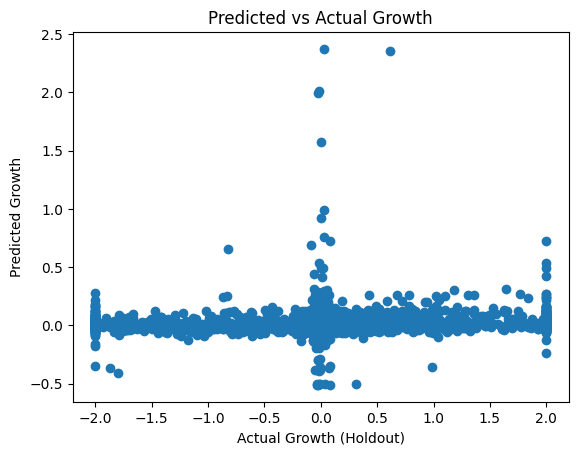

In [299]:
# Predicted vs Actual Growth Scatter
plt.figure()
plt.scatter(master.loc[X_holdout.index,"Target_Growth"], final_pred)
plt.xlabel("Actual Growth (Holdout)")
plt.ylabel("Predicted Growth")
plt.title("Predicted vs Actual Growth")
plt.show()

In [300]:
# Allocation Weight Ranking (Top 20 Portfolio)
top = output.sort_values("Allocation_Weight", ascending=False).head(20)

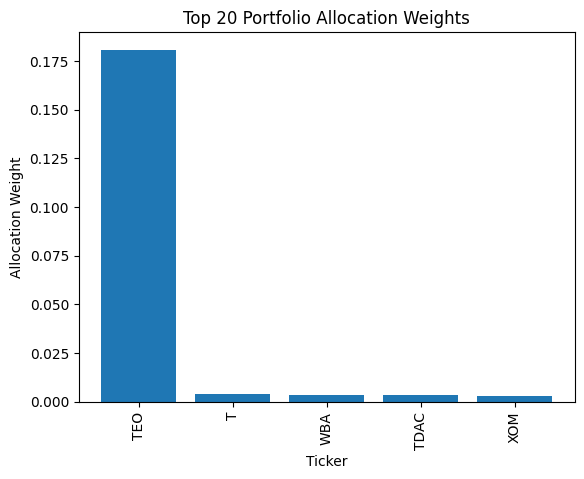

In [301]:
plt.figure()
plt.bar(top["Ticker"].astype(str), top["Allocation_Weight"])
plt.xticks(rotation=90)
plt.xlabel("Ticker")
plt.ylabel("Allocation Weight")
plt.title("Top 20 Portfolio Allocation Weights")
plt.show()

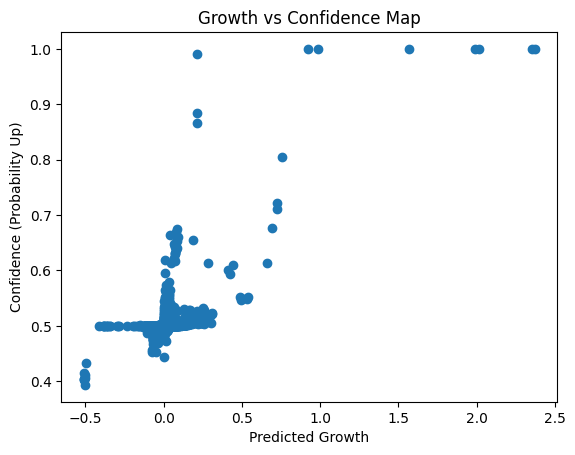

In [302]:
# Growth vs Confidence Scatter (Alpha Map)
plt.figure()
plt.scatter(output["Predicted_Growth"], output["Confidence"])
plt.xlabel("Predicted Growth")
plt.ylabel("Confidence (Probability Up)")
plt.title("Growth vs Confidence Map")
plt.show()

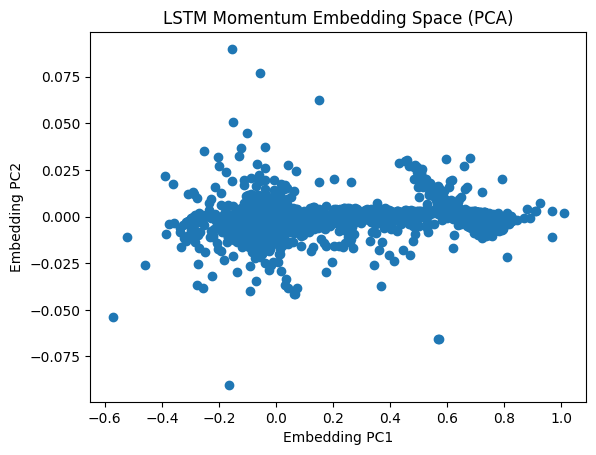

In [303]:
#LSTM Momentum Embedding PCA Visualization
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(lstm_embeddings)

plt.figure()
plt.scatter(emb_2d[:,0], emb_2d[:,1])
plt.xlabel("Embedding PC1")
plt.ylabel("Embedding PC2")
plt.title("LSTM Momentum Embedding Space (PCA)")
plt.show()

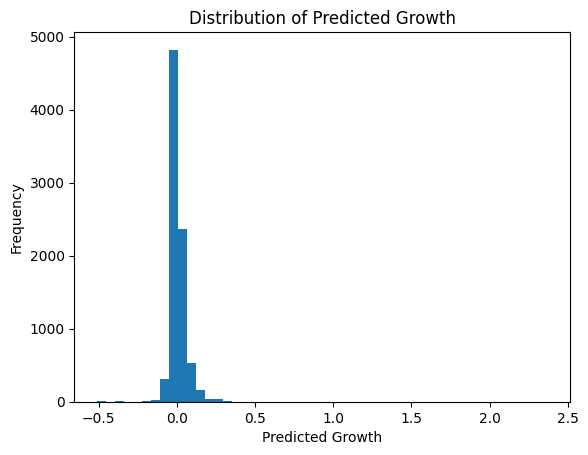

In [304]:
# Predicted Growth Distribution Histogram
plt.figure()
plt.hist(output["Predicted_Growth"], bins=50)
plt.xlabel("Predicted Growth")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Growth")
plt.show()

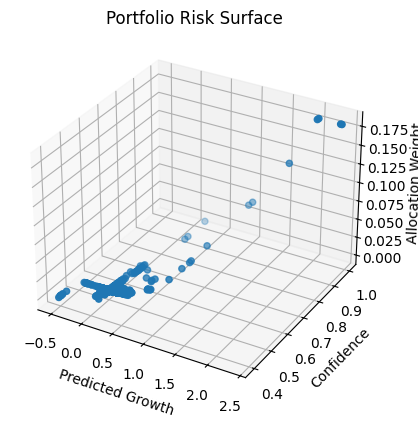

In [305]:
growth = output["Predicted_Growth"].values
confidence = output["Confidence"].values
weight = output["Allocation_Weight"].values

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(growth, confidence, weight)

ax.set_xlabel("Predicted Growth")
ax.set_ylabel("Confidence")
ax.set_zlabel("Allocation Weight")
ax.set_title("Portfolio Risk Surface")

plt.show()

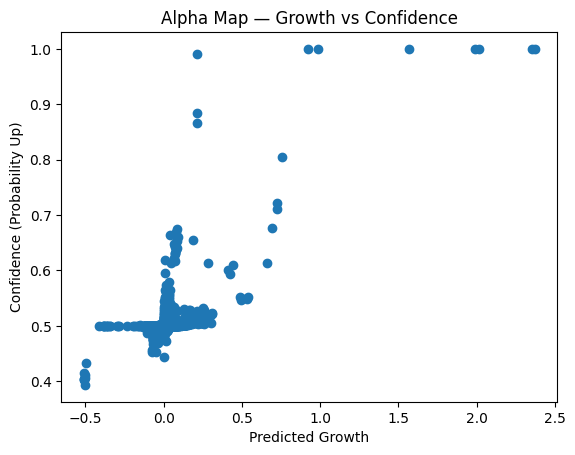

In [306]:
plt.figure()
plt.scatter(output["Predicted_Growth"], output["Confidence"])
plt.xlabel("Predicted Growth")
plt.ylabel("Confidence (Probability Up)")
plt.title("Alpha Map — Growth vs Confidence")
plt.show()

In [307]:
# Save portfolio output for Streamlit
output.to_csv("portfolio_output.csv", index=False)